In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sys
from tqdm import tqdm
import os
import pysam
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage,leaves_list
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import hamming, squareform
from scipy.spatial.distance import pdist, jaccard
from collections import OrderedDict

BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
FIG_DIR=BLOOD_MICROBIOME_PATH + 'results/herpesvirus/'

colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 

## Load / format data

In [2]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_virus  = pd.read_pickle(virus_file)
df_virus.index = [i[2] for i in df_virus.index]
df_virus = df_virus.transpose()
df_herpesvirus = df_virus[[c for c in df_virus.columns if 'herpesvirus' in c]].copy()




In [3]:
def InheritanceLabels(thresh = 10000, HHV  = 'Human betaherpesvirus 6B'):
    df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
    df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
    labels = ['low' for _ in df_herpesvirus.index]
    for n, i in enumerate(df_herpesvirus.index):
        if df_herpesvirus.loc[i][HHV] < thresh:
            continue
        fam = df_herpesvirus.loc[i].family
        df_fam = df_herpesvirus[(df_herpesvirus.family==fam)]
        if df_herpesvirus.loc[i].relationship=='sibling':
            if sum(df_fam[df_fam.relationship!='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            elif ('mother' not in df_fam.relationship.values) or ('father' not in df_fam.relationship.values):
                labels[n] = 'high HHV sample, not enough family members to confirm'
            else: labels[n] = 'high HHV child, low HHV parents'
        elif df_herpesvirus.loc[i].relationship!='sibling':
            if sum(df_fam[df_fam.relationship=='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            else:
                labels[n] = 'high HHV sample, not enough family members to confirm'
    return labels

        

In [4]:
df_6A = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6A']])
df_6A.columns = ['read counts']
df_6A['status'] = df_6A['read counts']>10000
df_6A['labels'] = InheritanceLabels(10000, 'Human betaherpesvirus 6A')
df_6A['HHV'] = ['6A_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_6B = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6B']])
df_6B.columns = ['read counts']
df_6B['status'] = df_6B['read counts']>10000
df_6B['labels'] = InheritanceLabels(10000, 'Human betaherpesvirus 6B')
df_6B['HHV'] = ['6B_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_7 = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 7']])
df_7.columns = ['read counts']
df_7['status'] = df_7['read counts']>10000
df_7['labels'] = InheritanceLabels(10000, 'Human betaherpesvirus 7')
df_7['HHV'] = ['7_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]
df_HHV =  pd.concat([df_6A, df_6B, df_7])
#df_HHV['read counts'] = np.log10(df_HHV['read_counts'] + 1)
df_HHV = df_HHV[['nan' not in i for i in df_HHV['HHV'].values]]


In [111]:
np.sum(df_6A.labels==df_6B.labels)

0.9912453490917049

In [117]:
print(np.mean(df_6A.labels=='high HHV sample with high HHV parents/offspring'))
print(np.mean(df_6B.labels=='high HHV sample with high HHV parents/offspring'))

print(np.sum(df_6B.labels=='high HHV sample with high HHV parents/offspring'))

print(np.mean((df_6A.labels=='high HHV sample with high HHV parents/offspring') &
             (df_6B.labels=='high HHV sample with high HHV parents/offspring')))

0.003064127817903261
0.003064127817903261
14
0.0


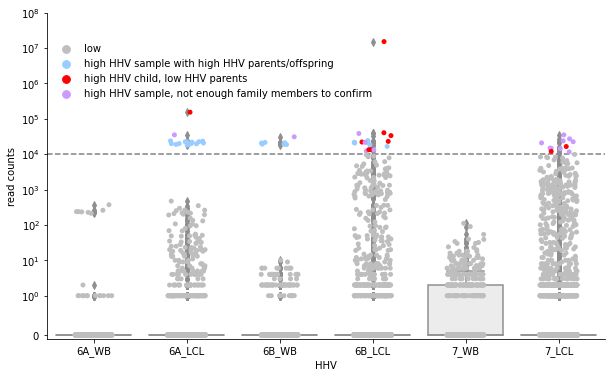

In [9]:
f, ax = plt.subplots(figsize=(10,6))
sns.set_palette(['#BEBEBE', '#99CCFF', '#FF0000', '#CC99FF'])
sns.stripplot(data =df_HHV, x='HHV', y='read counts', hue='labels', jitter=.2)
sns.boxplot(data =df_HHV, x='HHV', y='read counts', color='#ECECEC')

plt.yscale('symlog', linthresh=1)
plt.ylim(-.1,10e7)
plt.hlines(y=1e4, xmin=-.5, xmax=5.5, color='grey', linestyle='dashed')
ax.legend(loc='center left', bbox_to_anchor=(0, .82), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(FIG_DIR + 'iciHHV_read_counts.svg')
plt.show()

(array([ 3.,  3.,  5.,  6.,  8., 11., 10., 21., 26., 25., 17., 19., 25.,
        14., 15., 20., 13., 13., 23., 26.]),
 array([-4.54745471, -4.37215161, -4.19684851, -4.02154541, -3.84624231,
        -3.6709392 , -3.4956361 , -3.320333  , -3.1450299 , -2.9697268 ,
        -2.7944237 , -2.6191206 , -2.4438175 , -2.26851439, -2.09321129,
        -1.91790819, -1.74260509, -1.56730199, -1.39199889, -1.21669579,
        -1.04139269]),
 <BarContainer object of 20 artists>)

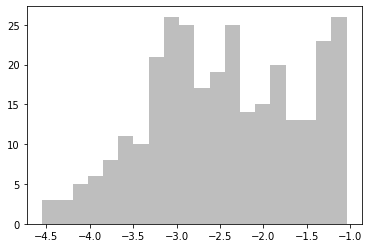

In [50]:
plt.hist(-np.log10(df_7[df_7['read counts']>10]['read counts'].values), bins=20)

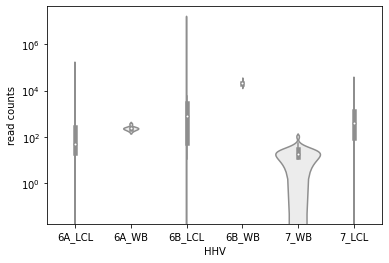

In [44]:
sns.violinplot(data =df_HHV[df_HHV['read counts']>10], x='HHV', y='read counts', color='#ECECEC')
plt.yscale('log')

In [26]:
df_HHV['sequencing_plate'] = bam_mappings.loc[df_HHV.index].sequencing_plate
df_HHV['family'] = bam_mappings.loc[df_HHV.index].family
df_HHV['asd'] = bam_mappings.loc[df_HHV.index].derived_affected_status
df_HHV['relationship'] = bam_mappings.loc[df_HHV.index].relationship

In [23]:
df_HHV

,read counts,status,labels,HHV,sequencing_plate,family,asd
MH0143019,0,False,low,6A_WB,MTR-00027,AU3859,autism
MH0143018,0,False,low,6A_WB,MTR-00027,AU3859,autism
MH0143013,1,False,low,6A_WB,MTR-00027,AU3859,NaN
MH0143009,0,False,low,6A_WB,MTR-00027,AU3859,NaN
MH0143008,0,False,low,6A_WB,MTR-00027,AU3859,NaN
...,...,...,...,...,...,...,...
02C10702,0,False,low,7_LCL,MTR-00010,AU1004,NaN
02C10543,1,False,low,7_LCL,MTR-00927,AU1005,autism
02C10542,0,False,low,7_LCL,MTR-00927,AU1005,broad-spectrum
02C10541,0,False,low,7_LCL,MTR-00927,AU1005,NaN


In [36]:
Counter(df_HHV[(df_HHV.HHV=='7_LCL') & (df_HHV['read counts'] > 100) & (df_HHV['read counts'] < 1000)].asd)

Counter({'autism': 64, nan: 43, 'nqa': 1, 'broad-spectrum': 2, 'not-met': 1})

In [34]:
Counter(df_HHV[(df_HHV.HHV=='7_LCL') & (df_HHV['read counts'] > 100) & (df_HHV['read counts'] < 1000)].relationship)

Counter({'sibling': 81, 'father': 15, 'mother': 15})

In [25]:
Counter(df_HHV[(df_HHV.HHV=='7_LCL') & (df_HHV['read counts'] > 100) & (df_HHV['read counts'] < 1000)].asd)

Counter({'autism': 64, nan: 43, 'nqa': 1, 'broad-spectrum': 2, 'not-met': 1})

# Check out numbers / correlation between counts to check for mismappings, etc.

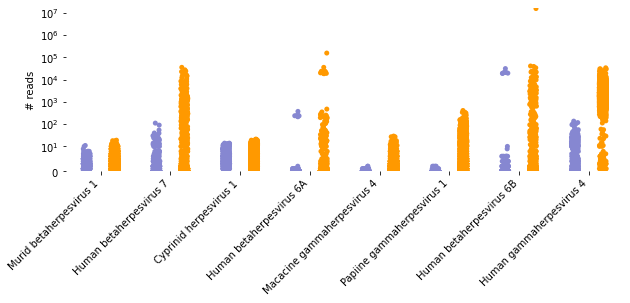

In [4]:
df_herpesvirus['sample'] = df_herpesvirus.index
df_herpesvirus['bio_seq_source'] = bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values
df_herpesvirus_melt = df_herpesvirus.melt(id_vars=['sample', 'bio_seq_source'])
plt.figure(figsize=(10,3))
sns.stripplot(data=df_herpesvirus_melt, x='variable', y='value', hue='bio_seq_source', order = list(set(df_herpesvirus_melt.variable)), dodge=True)
plt.yscale('symlog', linthresh=10)
plt.ylim(0,)
plt.xticks(rotation=45, ha='right')
plt.box(False)
plt.ylabel('# reads')
plt.xlabel('')
plt.legend().remove()
plt.savefig('%s/herpesviruses_abundances.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)
plt.savefig('%s/herpesviruses_abundances.svg' % FIG_DIR, 
transparent=True, bbox_inches='tight')#, dpi=300)

<Figure size 1440x1440 with 0 Axes>

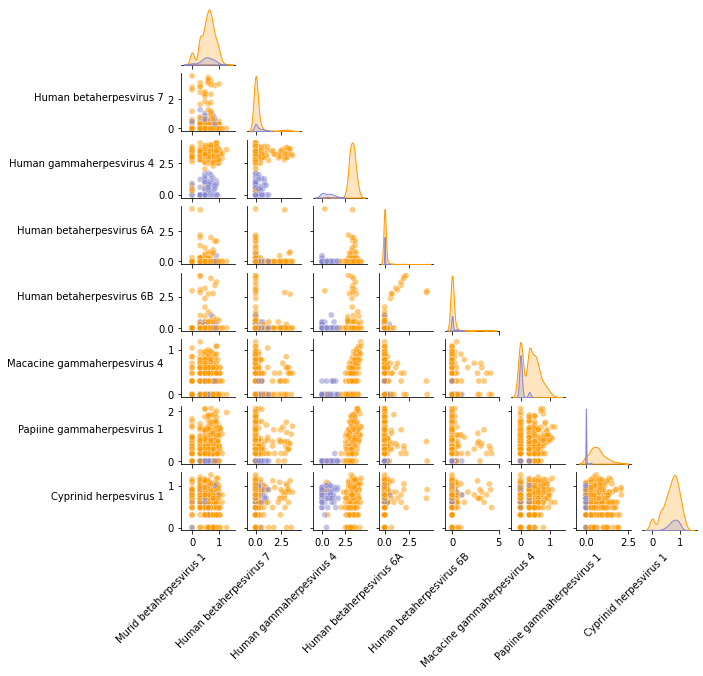

In [127]:
df_herpesvirus_log = df_herpesvirus.copy() # Convert to log
df_herpesvirus_log['bio_seq_source'] = bam_mappings.loc[df_herpesvirus.index].bio_seq_source 
for c in df_herpesvirus_log.columns[:8]:
    df_herpesvirus_log[c] = np.log10(df_herpesvirus_log[c]+1)
sns.set_palette(['#8687d1', '#ff9900'])
plt.figure(figsize=(20,20))
g = sns.pairplot(data=df_herpesvirus_log.sample(frac=.1), vars=df_herpesvirus_log.columns[:8], corner=True, height=1, hue='bio_seq_source',plot_kws={'alpha':0.5})
for ax in g.axes.flatten():
    try: ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha='right')
    except: do_nothing=True
    try: ax.set_xlabel(ax.get_xlabel(), rotation = 45, ha='right')
    except: do_nothing=True
g._legend.remove()
plt.savefig('%s/herpesviruses_pairplot.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)
plt.savefig('%s/herpesviruses_pairplot.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')#, dpi=300)
plt.show()

# Sort samples into categories.

## HHV-6A

In [31]:
df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
df_herpesvirus['MotherID'] = bam_mappings.loc[df_herpesvirus.index].MotherID
df_herpesvirus['FatherID'] = bam_mappings.loc[df_herpesvirus.index].FatherID
df_herpesvirus['participant_id'] = bam_mappings.loc[df_herpesvirus.index].participant_id

fams_with_possible_integration = set(df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>10e3)].family)
df_herpesvirus[[f in fams_with_possible_integration for f in df_herpesvirus.family]][['Human betaherpesvirus 6A', 'sample', 'bio_seq_source', 'relationship', 'family',
                                                                                      'MotherID', 'FatherID', 'participant_id']].sort_values('family').head(100)


,Human betaherpesvirus 6A,sample,bio_seq_source,relationship,family,MotherID,FatherID,participant_id
03C16026,17,03C16026,LCL,mother,AU0164,0,0,AU016401
03C16027,11,03C16027,LCL,sibling,AU0164,AU016401,AU016402,AU016403
03C16028,154033,03C16028,LCL,sibling,AU0164,AU016401,AU016402,AU016404
03C16639,18,03C16639,LCL,father,AU0164,0,0,AU016402
03C16816,0,03C16816,LCL,father,AU0358,AU035802,AU035801,AU035806
03C16815,21881,03C16815,LCL,mother,AU0358,0,0,AU035807
03C16817,0,03C16817,LCL,sibling,AU0358,AU035807,AU035806,AU035812
03C16818,22427,03C16818,LCL,sibling,AU0358,AU035807,AU035806,AU035813
03C17018,0,03C17018,LCL,mother,AU0358,AU035802,AU035801,AU035804
03C16918,6,03C16918,LCL,sibling,AU0358,AU035804,AU035803,AU035811


In [37]:
fams_with_possible_integration = set(df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>10e3)].family)
df_herpesvirus[[f in fams_with_possible_integration for f in df_herpesvirus.family]][['Human betaherpesvirus 6B', 'sample', 'bio_seq_source', 'relationship', 'family',
                                                                                      'MotherID', 'FatherID', 'participant_id']].sort_values('family').iloc[20:]


,Human betaherpesvirus 6B,sample,bio_seq_source,relationship,family,MotherID,FatherID,participant_id
02C10857,4,02C10857,LCL,sibling,AU0918,AU0918202,AU0918201,AU0918301
02C10856,2,02C10856,LCL,mother,AU0918,0,0,AU0918202
02C10956,2,02C10956,LCL,mother,AU0922,0,0,AU0922202
02C10955,2,02C10955,LCL,father,AU0922,0,0,AU0922201
02C10954,13410,02C10954,LCL,sibling,AU0922,AU0922202,AU0922201,AU0922301
02C10953,0,02C10953,LCL,sibling,AU0922,AU0922202,AU0922201,AU0922302
04C37710,1,04C37710,LCL,father,AU1338,0,0,AU1338201
04C37711,13199,04C37711,LCL,mother,AU1338,0,0,AU1338202
04C37712,3,04C37712,LCL,sibling,AU1338,AU1338202,AU1338201,AU1338302
04C37713,7,04C37713,LCL,sibling,AU1338,AU1338202,AU1338201,AU1338304


**Sibling AU3295 has icicHHV 6B, but no parents.**

In [6]:
df_herpesvirus['6A_status'] = 'low'
df_herpesvirus.loc[df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6A']>4].index,'6A_status'] = 'iciHHV'
df_herpesvirus.loc['03C16028','6A_status'] = '03C16028_weird_sample'

### iciHHV-6A
- AU0164: 03C16028 has very high HHV-6B (and thus slightly high HHV-6A), no other family members with high HHV-6A
- AU0358: Mom and sibling with high HHV-6A.
- AU0549: Just father has high HHV-6A.
- AU0598: Father and two siblings have iciHHV-6A.
- AU0705: Father and sibling have iciHHV-6A.
- AU1608: Mother and sibling have high iciHHV-6A.
- AU1655: Father and two siblings have high iciHHV-6B.

In [7]:
df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
df_herpesvirus['MotherID'] = bam_mappings.loc[df_herpesvirus.index].MotherID
df_herpesvirus['FatherID'] = bam_mappings.loc[df_herpesvirus.index].FatherID
df_herpesvirus['participant_id'] = bam_mappings.loc[df_herpesvirus.index].participant_id

fams_with_possible_integration = set(df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>4)].family)
df_herpesvirus[[f in fams_with_possible_integration for f in df_herpesvirus.family]][['Human betaherpesvirus 6B', 'sample', 'bio_seq_source', 'relationship', 'family',
                                                                                      'MotherID', 'FatherID', 'participant_id']].sort_values('family').head()
#bam_mappings.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>3)].index][['relationship', 'family']]

,Human betaherpesvirus 6B,sample,bio_seq_source,relationship,family,MotherID,FatherID,participant_id
03C16639,3.124504,03C16639,LCL,father,AU0164,0,0,AU016402
03C16027,3.049993,03C16027,LCL,sibling,AU0164,AU016401,AU016402,AU016403
03C16028,7.184550,03C16028,LCL,sibling,AU0164,AU016401,AU016402,AU016404
03C16026,3.122871,03C16026,LCL,mother,AU0164,0,0,AU016401
03C15782,0.301030,03C15782,LCL,mother,AU0340,0,0,AU034001


### iciHHV-6B
- AU0164:  03C16028 has VERY high HHV-6B, other families have medium amount (~1000 reads) but not consistent with iciHHV 
- AU0340:  Just father.
- AU0412: Mother and two siblings
- AU0800: Mother and sibling.
- AU0918: 02C10855 has high HHV-6B, mother and father don't. (LCL)
- AU0922: 02C10954 has high HHV-6B, mother and father don't. (LCL)
- AU1338: Mother does, no one else.
- AU1589: Father and two siblings do.
- AU1609: 05C48098 has high HHV-6B, mother and father don't. (LCL)
- AU1825: 06C61448 has high HHV-6B, mother and father don't. (LCL)
- AU1920: Only father.
- AU1931: 08C78108 has high HHV, mother doesn't and no father in database.
- AU1953: 07C66885 has high HHV-6B, mother and father don't. (LCL)
- AU2140: Sibling & father. (WB)
- AU3295: 09C90889, mother and father don't (LCL).
- AU3761: Mother and sibling.(WB)
- AU3792: 11C120675 has high, but sequencing cancalled for family. (WB).
- AU4056: Mother and sibling. (WB)

In [8]:
probable_iciHHV_fams = {'AU0412', 'AU0800', 'AU4056', 'AU3761', 'AU2140', 'AU1589', }
unknown_HHV_fams = {'AU0340', 'AU1338', 'AU1920' , 'AU3792'}
LCL_high_HHV = {'AU0918', 'AU0922', 'AU1609', 'AU1825', 'AU1931', 'AU1953', 'AU3295'}
df_herpesvirus['6B_status'] = 'low'

df_herpesvirus.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>3)].index,'6B_status'] = 'medium'
df_herpesvirus.loc['03C16028','6B_status'] = '03C16028_weird_sample'
df_herpesvirus.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>4) & np.array([f in probable_iciHHV_fams for f in df_herpesvirus.family])].index,'6B_status'] = 'iciHHV'
df_herpesvirus.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>4) & np.array([f in unknown_HHV_fams for f in df_herpesvirus.family])].index,'6B_status'] = 'unknown'
df_herpesvirus.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>4) & np.array([f in LCL_high_HHV for f in df_herpesvirus.family])].index,'6B_status'] = 'LCL_high'

## HHV 7

In [9]:
df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
df_herpesvirus['MotherID'] = bam_mappings.loc[df_herpesvirus.index].MotherID
df_herpesvirus['FatherID'] = bam_mappings.loc[df_herpesvirus.index].FatherID
df_herpesvirus['participant_id'] = bam_mappings.loc[df_herpesvirus.index].participant_id

fams_with_possible_integration = set(df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>4)].family)
df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>4)][['Human betaherpesvirus 7', 'sample', 'bio_seq_source', 'relationship', 'family',
                                                                                      'MotherID', 'FatherID', 'participant_id']].sort_values('family')
#bam_mappings.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>3)].index][['relationship', 'family']]

,Human betaherpesvirus 7,sample,bio_seq_source,relationship,family,MotherID,FatherID,participant_id
05C45648,4.319293,05C45648,LCL,father,AU0352,0,0,AU035206
03C23216,4.079796,03C23216,LCL,sibling,AU0980,AU0980202,AU0980201,AU0980307
06C61532,4.547467,06C61532,LCL,mother,AU0983,0,0,AU0983202
04C34156,4.168055,04C34156,LCL,mother,AU1009,0,0,AU1009202
04C34171,4.171141,04C34171,LCL,father,AU1083,0,0,AU1083201
05C41995,4.217326,05C41995,LCL,sibling,AU1309,AU1309202,AU1309201,AU1309302
06C53580,4.065505,06C53580,LCL,mother,AU1433,0,0,AU1433204
07C69550,4.352395,07C69550,LCL,mother,AU1647,0,0,AU1647202
07C68436,4.434968,07C68436,LCL,father,AU1749,0,0,AU1749201
07C66834,4.155123,07C66834,LCL,father,AU1813,0,0,AU1813201


In [10]:
df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
df_herpesvirus['MotherID'] = bam_mappings.loc[df_herpesvirus.index].MotherID
df_herpesvirus['FatherID'] = bam_mappings.loc[df_herpesvirus.index].FatherID
df_herpesvirus['participant_id'] = bam_mappings.loc[df_herpesvirus.index].participant_id

fams_with_possible_integration = set(df_herpesvirus[(df_herpesvirus['Human gammaherpesvirus 4']>4)].family)
df_herpesvirus[(df_herpesvirus['Human gammaherpesvirus 4']>4)][['Human gammaherpesvirus 4', 'sample', 'bio_seq_source', 'relationship', 'family',
                                                                                      'MotherID', 'FatherID', 'participant_id']].sort_values('family').iloc[:10]
#bam_mappings.loc[df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>3)].index][['relationship', 'family']]

,Human gammaherpesvirus 4,sample,bio_seq_source,relationship,family,MotherID,FatherID,participant_id
03C16791,4.018700,03C16791,LCL,sibling,AU0022,AU002201,AU002202,AU002205
HI0205,4.069372,HI0205,LCL,sibling,AU0030,AU003001,AU003002,AU003004
03C16263,4.123133,03C16263,LCL,father,AU0084,0,0,AU008402
03C15797,4.022057,03C15797,LCL,father,AU0109,0,0,AU010902
03C15789,4.014100,03C15789,LCL,sibling,AU0123,AU012301,AU012302,AU012305
03C16091,4.240300,03C16091,LCL,mother,AU0150,0,0,AU015001
03C14346,4.135133,03C14346,LCL,sibling,AU0179,AU017901,AU017902,AU017905
08C72913,4.182586,08C72913,LCL,mother,AU0226,0,0,AU0226202
03C14344,4.122445,03C14344,LCL,sibling,AU0235,AU023501,AU023502,AU023504
03C16774,4.063296,03C16774,LCL,mother,AU0282,0,0,AU028201


# Coverages

In [11]:
herpes_6a_contig = 'kraken:taxid|32603|NC_001664.4'
herpes_6b_contig = 'kraken:taxid|32604|NC_000898.1'
herpes_7_contig = 'kraken:taxid|10372|NC_001716.2'
herpes_4_contig = 'kraken:taxid|10376|NC_007605.1'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'
with open(BLOOD_MICROBIOME_PATH + 'data/reference_genomes/hg38_and_herpes.fa') as output_handle:
    seq_lengths = {r.id:len(r) for r in SeqIO.parse(output_handle, "fasta")}

In [12]:
coverages = np.load(BLOOD_MICROBIOME_PATH + 'results/herpesvirus/coverages.npy', allow_pickle=True).item()
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages.values()]:
    counter_sum = counter_sum + c

In [13]:
Counter({k:counter_sum[k] for k in counter_sum if ((herpes_6a_contig in k) or (herpes_6b_contig in k) or (herpes_7_contig in k))}).most_common(10)

[(('kraken:taxid|10372|NC_001716.2', 'kraken:taxid|10372|NC_001716.2'),
  11723278),
 (('kraken:taxid|32604|NC_000898.1', 'kraken:taxid|32604|NC_000898.1'),
  9804469),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32603|NC_001664.4'),
  2380918),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32604|NC_000898.1'),
  198374),
 (('chrUn_JTFH01000690v1_decoy', 'kraken:taxid|32604|NC_000898.1'), 31454),
 (('chr1', 'kraken:taxid|32604|NC_000898.1'), 19277),
 (('chr2', 'kraken:taxid|32604|NC_000898.1'), 16586),
 (('chr18', 'kraken:taxid|32604|NC_000898.1'), 14744),
 (('chr3', 'kraken:taxid|32604|NC_000898.1'), 13458),
 (('chr5', 'kraken:taxid|32604|NC_000898.1'), 12623)]

In [14]:
df_herpesvirus['h6a_pair'] = 0
df_herpesvirus['h6a_decoy'] = 0
df_herpesvirus['h6b_pair'] = 0
df_herpesvirus['h6b_decoy'] = 0
for c in tqdm(coverages):
    h6a_pair = 0
    h6a_decoy = 0
    h6b_pair = 0
    h6b_decoy = 0
    if (herpes_6a_contig, herpes_6a_contig) in coverages[c]:
        h6a_pair = coverages[c][(herpes_6a_contig, herpes_6a_contig)][2]
    if (decoy_contig, herpes_6a_contig) in coverages[c]:
        h6a_decoy = coverages[c][(decoy_contig, herpes_6a_contig)][2]
    if (herpes_6b_contig, herpes_6b_contig) in coverages[c]:
        h6b_pair = coverages[c][(herpes_6b_contig, herpes_6b_contig)][2]
    if (decoy_contig, herpes_6b_contig) in coverages[c]:
        h6b_decoy = coverages[c][(decoy_contig, herpes_6b_contig)][2]
    df_herpesvirus.loc[c, ['h6a_pair', 'h6a_decoy', 'h6b_pair', 'h6b_decoy']] = [h6a_pair, h6a_decoy, h6b_pair, h6b_decoy]

100%|██████████| 4521/4521 [00:12<00:00, 366.03it/s]


In [23]:
def GetCoverages(sample_name):
    sample_dir = BLOOD_MICROBIOME_PATH + 'intermediate_files/herpesvirus/%s' % sample_name
    with pysam.AlignmentFile(sample_dir + '.paired_aligned_to_hg38_herpes.sam', 'r') as samfile:
        reads = [r for r in samfile.fetch() if not r.is_supplementary]
    with pysam.AlignmentFile(sample_dir + '.single_aligned_to_hg38_herpes.sam', 'r') as samfile:
        reads =  reads + [r for r in samfile.fetch() if not r.is_supplementary]
    with pysam.AlignmentFile(sample_dir + '.single_original_alignment.sam', 'r') as samfile:
        reads = reads + [r for r in samfile.fetch()  if not r.is_supplementary]

    read_dict = {}
    pair_dict = {}
    for r in reads:
        if r.query_name in read_dict:
            read2 = r
            read1 = read_dict[r.query_name]
            read1_reference_name = read1.reference_name
            read2_reference_name = read2.reference_name
            if (read1_reference_name not in herpes_contigs) and (read2_reference_name not in herpes_contigs): continue
            read1 = read_dict[r.query_name]
            if not read1_reference_name: read1_reference_name = 'unmapped'
            if not read2_reference_name: read2_reference_name = 'unmapped'
            if read1_reference_name < read2_reference_name:
                pair_key = (read1_reference_name, read2_reference_name)
                pair_value = [(read1.positions, read2.positions)]
            else:
                pair_key = (read2_reference_name, read1_reference_name)
                pair_value = [(read2.positions, read1.positions)]
            
            if pair_key in pair_dict:
                pair_dict[pair_key] = pair_dict[pair_key] + pair_value
            else: 
                pair_dict[pair_key] =  pair_value
        else:
            read_dict[r.query_name] = r
    return {k:(Counter(np.concatenate([p[0] for p in pair_dict[k]])),Counter(np.concatenate([p[1] for p in pair_dict[k]])), len(pair_dict[k])) for k in pair_dict}
 

In [25]:
a = GetCoverages('06C53149')

ValueError: file has no sequences defined (mode='r') - is it SAM/BAM format? Consider opening with check_sq=False

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


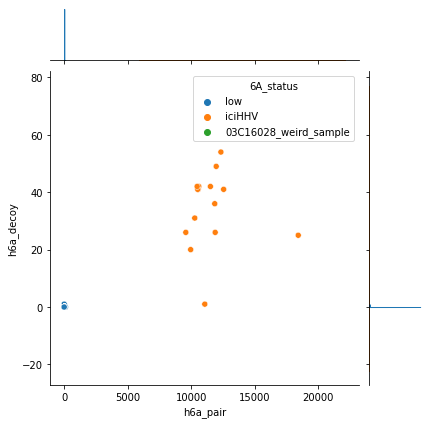

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


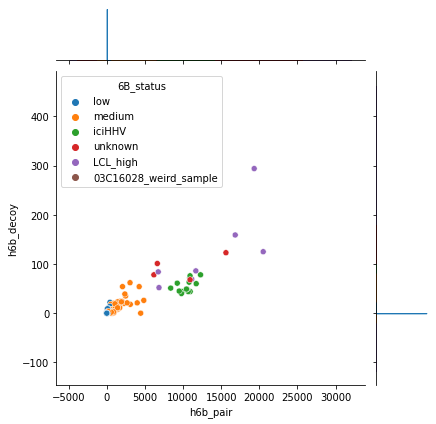

In [15]:
sns.jointplot(data=df_herpesvirus, x='h6a_pair', y='h6a_decoy', hue='6A_status')
plt.show()

sns.jointplot(data=df_herpesvirus, x='h6b_pair', y='h6b_decoy', hue='6B_status')
plt.show()


In [20]:
df_herpesvirus[df_herpesvirus['h6a_pair']>10000]

,Murid betaherpesvirus 1,Human betaherpesvirus 7,Human gammaherpesvirus 4,Human betaherpesvirus 6A,Human betaherpesvirus 6B,Macacine gammaherpesvirus 4,Papiine gammaherpesvirus 1,Cyprinid herpesvirus 1,sample,bio_seq_source,...,relationship,MotherID,FatherID,participant_id,6A_status,6B_status,h6a_pair,h6a_decoy,h6b_pair,h6b_decoy
06C54351,0.602060,0.000000,3.055378,4.293208,2.854306,0.000000,0.301030,0.602060,06C54351,LCL,...,sibling,AU1608202,AU1608201,AU1608302,iciHHV,low,10280,31,89,4
06C54349,0.698970,0.000000,3.264818,4.299006,2.884795,0.477121,0.602060,0.477121,06C54349,LCL,...,sibling,AU1608202,AU1608201,AU1608304,iciHHV,low,10600,42,51,0
06C54347,0.602060,0.000000,2.779596,4.355873,2.919601,0.000000,0.845098,0.301030,06C54347,LCL,...,mother,0,0,AU1608202,iciHHV,low,11970,49,95,3
06C53151,0.477121,0.000000,3.646894,4.297804,2.885926,0.778151,0.301030,0.903090,06C53151,LCL,...,father,0,0,AU1655201,iciHHV,low,10546,41,51,4
06C53149,0.602060,0.000000,3.755722,4.316767,2.911690,0.698970,1.079181,0.845098,06C53149,LCL,...,sibling,AU1655202,AU1655201,AU1655302,iciHHV,low,11071,1,74,0
06C53148,0.301030,2.850646,3.264818,4.296160,2.850646,0.301030,0.778151,0.698970,06C53148,LCL,...,sibling,AU1655202,AU1655201,AU1655301,iciHHV,low,10513,41,69,1
04C37990,0.477121,0.000000,3.409595,4.369439,2.961895,0.301030,0.602060,1.000000,04C37990,LCL,...,sibling,AU059801,AU059802,AU059805,iciHHV,low,12340,54,68,5
03C16818,0.477121,0.000000,3.541205,4.350791,2.954725,0.477121,0.602060,0.903090,03C16818,LCL,...,sibling,AU035807,AU035806,AU035813,iciHHV,low,11855,36,74,4
03C16815,0.778151,0.000000,3.300161,4.340087,2.919601,0.301030,0.301030,1.000000,03C16815,LCL,...,mother,0,0,AU035807,iciHHV,low,11514,42,70,8
03C16633,0.301030,0.000000,3.051924,4.353801,2.926857,0.000000,0.477121,1.000000,03C16633,LCL,...,father,0,0,AU070502,iciHHV,low,11890,26,81,5


In [19]:
def PlotCoverages(contig, decoy_contig, coverages):
    key = (min(contig, decoy_contig), max(decoy_contig, contig))
    f, ax = plt.subplots(ncols=3, figsize=(20,3))
    y0_n = 0
    y1_n = 0
    y2_n = 0
    for i,coverage in tqdm(enumerate(coverages)):
        # Proper pairs of herpesvirus.
        key=(contig, contig)
        zero_count_holder = Counter({i:0 for i in range(0, seq_lengths[contig])})
        if key in coverage:
            # Plot coverage of proper HHV pairs.
            d = coverage[key][0] + coverage[key][1]
            d = {key: d.get(key, 0) + zero_count_holder.get(key, 0)
              for key in set(d) | set(zero_count_holder)}
        else: d = zero_count_holder
        ord_dict = OrderedDict(sorted(d.items()))
        x0 = list(ord_dict.keys())
        y0 = list(ord_dict.values())
        y0 = np.array(y0)/sum(y0)
        if y0_n == 0:
            y0_total = np.array(y0)
        else: y0_total = y0_total + np.array(y0)
        y0_n = y0_n + 1
        ax[0].plot([np.mean(x0[i:(i+300)]) for i in range(len(x0)-300)], [np.mean(y0[i:(i+300)]) for i in range(len(y0)-300)], 'grey', alpha=.5)
        
        
        # Plot coverage of HHV reads that are mated w/decoy.
        key=(min(contig, decoy_contig), max(decoy_contig, contig))
        zero_count_holder = Counter({i:0 for i in range(0, seq_lengths[contig])})
        if key in coverage:
            d = coverage[key][1]
            d = {key: d.get(key, 0) + zero_count_holder.get(key, 0)
              for key in set(d) | set(zero_count_holder)}
        else: d = zero_count_holder    
        ord_dict = OrderedDict(sorted(d.items()))
        x1 = list(ord_dict.keys())
        y1 = list(ord_dict.values())
        y1 = np.array(y1)/sum(y1)
        if y1_n == 0:
            y1_total = np.array(y1)
        else: y1_total = y1_total + np.array(y1)
        y1_n = y1_n + 1
        ax[1].plot([np.mean(x1[i:(i+10)]) for i in range(len(x1)-10)], [np.mean(y1[i:(i+10)]) for i in range(len(y1)-10)], 'grey', alpha=.5)
        
        
        # Plot coverage of decoy reads that are mated w/HHV.
        key=(min(contig, decoy_contig), max(decoy_contig, contig))
        zero_count_holder = Counter({i:0 for i in range(0, seq_lengths[decoy_contig])})
        if key in coverage[key][0]:
            d = coverage[key][0]
            d = {key: d.get(key, 0) + zero_count_holder.get(key, 0)
              for key in set(d) | set(zero_count_holder)}
        else: d = zero_count_holder
        ord_dict = OrderedDict(sorted(d.items()))
        x2 = list(ord_dict.keys())
        y2 = list(ord_dict.values())
        y2 = np.array(y2)/sum(y2)
        if y2_n == 0:
            y2_total = np.array(y2)
        else: y2_total = y2_total + np.array(y2)
        y2_n = y2_n + 1
        ax[2].plot([np.mean(x2[i:(i+10)]) for i in range(len(x2)-10)], [np.mean(y2[i:(i+10)]) for i in range(len(y2)-10)], 'grey', alpha=.5)
        
        
    ax[0].plot([np.mean(x0[i:(i+10)]) for i in range(len(x0)-10)], [np.mean(y0_total[i:(i+10)])/y0_n for i in range(len(y0_total)-10)], 'orange')
    ax[1].plot([np.mean(x1[i:(i+10)]) for i in range(len(x1)-10)], [np.mean(y1_total[i:(i+10)])/y1_n for i in range(len(y1_total)-10)], 'orange')
    ax[2].plot([np.mean(x2[i:(i+10)]) for i in range(len(x2)-10)], [np.mean(y2_total[i:(i+10)])/y2_n for i in range(len(y2_total)-10)], 'orange')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    return ax

In [97]:
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages.values()]:
    counter_sum = counter_sum + c

# Herpes 6A

## iciHHV

0it [00:00, ?it/s]


TypeError: 'in <string>' requires string as left operand, not tuple

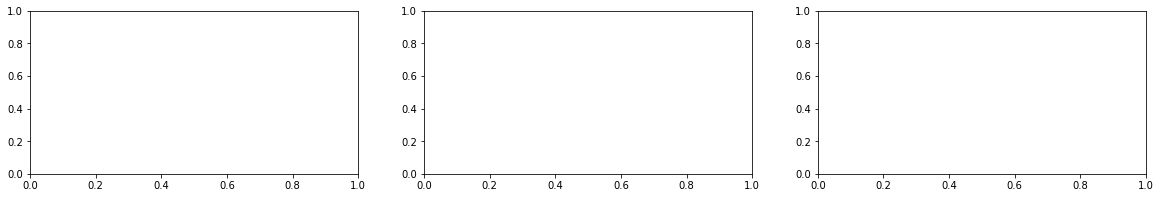

In [21]:
decoy_contig='chrUn_JTFH01000690v1_decoy'
ax = PlotCoverages(herpes_6b_contig, decoy_contig,  {c:coverages[c] for c in coverages if df_herpesvirus.loc[c]['6A_status']=='iciHHV'})
ax[0].set_title('HHV-6A reads mated with HHV-6A')
ax[0].set_ylabel('Coverage (log-scaled)')
ax[0].set_xlabel('HHV-6A position')
ax[1].set_xlabel('HHV-6A position')
ax[2].set_xlabel('%s position' % decoy_contig)

ax[1].set_title('HHV-6A reads mated with %s' % decoy_contig)
ax[2].set_title('%s reads mated with HHV-6A' % decoy_contig)
for i in range(3):
    ax[i].set_yticks([])
    ax[i].set(frame_on=False)
    ax[i].locator_params(nbins=5)
plt.suptitle('HHV-6A, Unknown iciHHV state', y=1.1)
plt.tight_layout()
plt.savefig(fig_dir + 'hhv_6A_unknown_ici.svg', transparent=True, bbox_inches='tight')#, format='png', dpi=500)
plt.show()

# Herpes 6B

In [38]:
coverages = []
for sample_name in df_herpesvirus[df_herpesvirus['6B_status']=='iciHHV'].index:
    try:
        coverages = coverages + [GetCoverages(sample_name)]
    except: donothing=True
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages]:
    counter_sum = counter_sum + c

In [43]:
print('herpes 6B')
Counter({k:counter_sum[k] for k in counter_sum if herpes_6b_contig in k}).most_common(5)

herpes 6B


[(('kraken:taxid|32604|NC_000898.1', 'kraken:taxid|32604|NC_000898.1'),
  2028436),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32604|NC_000898.1'), 31441),
 (('chrUn_JTFH01000690v1_decoy', 'kraken:taxid|32604|NC_000898.1'), 5121),
 (('chr18', 'kraken:taxid|32604|NC_000898.1'), 4699),
 (('chr1', 'kraken:taxid|32604|NC_000898.1'), 4519),
 (('chr2', 'kraken:taxid|32604|NC_000898.1'), 4234),
 (('chr10', 'kraken:taxid|32604|NC_000898.1'), 2971),
 (('chr3', 'kraken:taxid|32604|NC_000898.1'), 2942),
 (('chrX', 'kraken:taxid|32604|NC_000898.1'), 2911),
 (('chr7', 'kraken:taxid|32604|NC_000898.1'), 2819)]


0it [00:00, ?it/s]
1it [00:20, 20.05s/it]
2it [00:40, 20.02s/it]
3it [01:00, 20.02s/it]
4it [01:20, 20.02s/it]
5it [01:40, 20.02s/it]
6it [02:00, 20.02s/it]
7it [02:20, 20.04s/it]
8it [02:40, 20.02s/it]
9it [03:00, 19.99s/it]
10it [03:19, 19.96s/it]
11it [03:39, 19.96s/it]
12it [03:59, 19.95s/it]
13it [04:19, 19.97s/it]
14it [04:27, 19.11s/it]


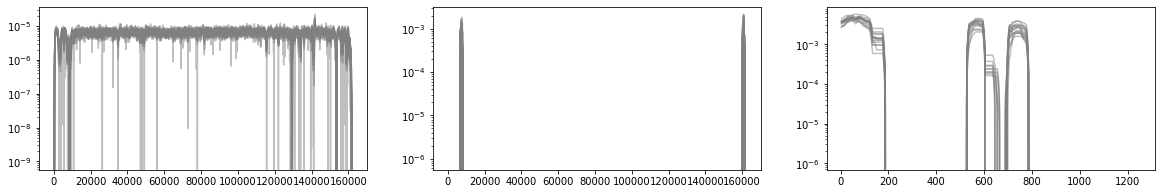

In [44]:
PlotCoverages(herpes_6b_contig, 'chrUn_JTFH01000690v1_decoy', coverages)

# Unknown

In [67]:
coverages = []
for sample_name in df_herpesvirus[df_herpesvirus['6B_status']=='unknown'].index:
    try:
        coverages = coverages + [GetCoverages(sample_name)]
    except: donothing=True
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages]:
    counter_sum = counter_sum + c

In [56]:
print('herpes 6B')
Counter({k:counter_sum[k] for k in counter_sum if herpes_6b_contig in k}).most_common(5)

herpes 6B


[(('kraken:taxid|32604|NC_000898.1', 'kraken:taxid|32604|NC_000898.1'),
  467143),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32604|NC_000898.1'), 6437),
 (('chrUn_JTFH01000690v1_decoy', 'kraken:taxid|32604|NC_000898.1'), 1520),
 (('chr18', 'kraken:taxid|32604|NC_000898.1'), 1482),
 (('chr1', 'kraken:taxid|32604|NC_000898.1'), 1414)]


0it [00:00, ?it/s]/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide

1it [00:21, 21.12s/it]


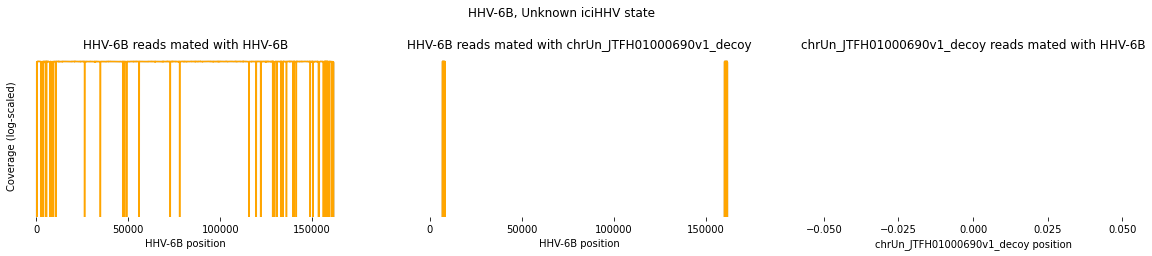

In [95]:
decoy_contig='chrUn_JTFH01000690v1_decoy'
ax = PlotCoverages(herpes_6b_contig, decoy_contig, coverages[:1])
ax[0].set_title('HHV-6B reads mated with HHV-6B')
ax[0].set_ylabel('Coverage (log-scaled)')
ax[0].set_xlabel('HHV-6B position')
ax[1].set_xlabel('HHV-6B position')
ax[2].set_xlabel('%s position' % decoy_contig)

ax[1].set_title('HHV-6B reads mated with %s' % decoy_contig)
ax[2].set_title('%s reads mated with HHV-6B' % decoy_contig)
for i in range(3):
    ax[i].set_yticks([])
    ax[i].set(frame_on=False)
    ax[i].locator_params(nbins=5)
plt.suptitle('HHV-6B, Unknown iciHHV state', y=1.1)
plt.tight_layout()
plt.savefig(fig_dir + 'hhv_6b_unknown_ici.svg' 
                transparent=True, bbox_inches='tight')#, format='png', dpi=500)
plt.show()

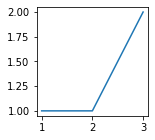

In [90]:
def plot_signal(x,y):
    # Skipping a lot of other complexity her
    f, ax = plt.subplots(figsize=(2,2))
    ax.plot(x,y)
    # further stuff
    return ax

ax = plot_signal([1,2,3], [1,1,2])
p
plt.show()

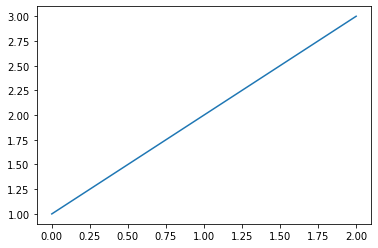

In [84]:
ax=testplot()


## LCL high

In [59]:
coverages = []
for sample_name in df_herpesvirus[df_herpesvirus['6B_status']=='LCL_high'].index:
    try:
        coverages = coverages + [GetCoverages(sample_name)]
    except: donothing=True
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages]:
    counter_sum = counter_sum + c

In [61]:
print('herpes 6B')
Counter({k:counter_sum[k] for k in counter_sum if herpes_6b_contig in k}).most_common(10)

herpes 6B


[(('kraken:taxid|32604|NC_000898.1', 'kraken:taxid|32604|NC_000898.1'),
  936243),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32604|NC_000898.1'), 14811),
 (('chr10', 'kraken:taxid|32604|NC_000898.1'), 3360),
 (('chr1', 'kraken:taxid|32604|NC_000898.1'), 3240),
 (('chr7', 'kraken:taxid|32604|NC_000898.1'), 3051),
 (('chrUn_JTFH01000690v1_decoy', 'kraken:taxid|32604|NC_000898.1'), 2906),
 (('chr2', 'kraken:taxid|32604|NC_000898.1'), 2771),
 (('chr18', 'kraken:taxid|32604|NC_000898.1'), 2662),
 (('chr5', 'kraken:taxid|32604|NC_000898.1'), 2442),
 (('chr12', 'kraken:taxid|32604|NC_000898.1'), 2430)]


0it [00:00, ?it/s]
1it [00:20, 20.60s/it]
2it [00:41, 20.62s/it]
3it [01:01, 20.60s/it]
4it [01:22, 20.61s/it]
5it [01:42, 20.53s/it]
6it [02:03, 20.54s/it]
7it [02:11, 18.76s/it]


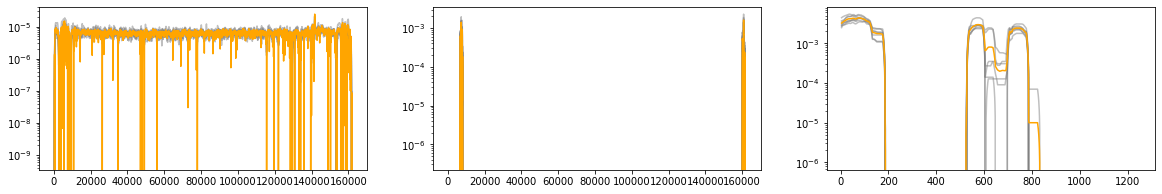

In [62]:
PlotCoverages(herpes_6b_contig, 'chrUn_JTFH01000690v1_decoy', coverages)

# Herpes 7

In [38]:
coverages = []
for sample_name in df_herpesvirus[df_herpesvirus['7_status']=='iciHHV'].index:
    try:
        coverages = coverages + [GetCoverages(sample_name)]
    except: donothing=True
counter_sum = Counter()
for c in [Counter({k:len(c[k][0]) for k in c}) for c in coverages]:
    counter_sum = counter_sum + c

In [43]:
print('herpes 7')
Counter({k:counter_sum[k] for k in counter_sum if herpes_7_contig in k}).most_common(5)

herpes 6B


[(('kraken:taxid|32604|NC_000898.1', 'kraken:taxid|32604|NC_000898.1'),
  2028436),
 (('kraken:taxid|32603|NC_001664.4', 'kraken:taxid|32604|NC_000898.1'), 31441),
 (('chrUn_JTFH01000690v1_decoy', 'kraken:taxid|32604|NC_000898.1'), 5121),
 (('chr18', 'kraken:taxid|32604|NC_000898.1'), 4699),
 (('chr1', 'kraken:taxid|32604|NC_000898.1'), 4519),
 (('chr2', 'kraken:taxid|32604|NC_000898.1'), 4234),
 (('chr10', 'kraken:taxid|32604|NC_000898.1'), 2971),
 (('chr3', 'kraken:taxid|32604|NC_000898.1'), 2942),
 (('chrX', 'kraken:taxid|32604|NC_000898.1'), 2911),
 (('chr7', 'kraken:taxid|32604|NC_000898.1'), 2819)]


2it [00:00, 7275.46it/s]


UnboundLocalError: local variable 'x0' referenced before assignment

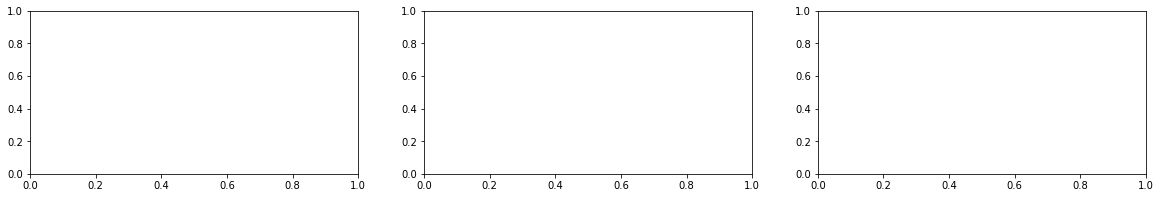

In [64]:
PlotCoverages(herpes_7_contig, 'chrUn_JTFH01000690v1_decoy', coverages[:2])